**Notebook and materials: https://github.com/VProv/uncertainty_example**

## Structure of this notebook:
#### 1) Uncertainty and deep ensembles for classification
#### 2) Uncertainty and deep ensembles for regression
#### 3) Ensemble distribution distillation and Prior networks for regression

## Deep ensembles for classification

### Why ensembles?

#### Assume that we have an ensemble of different probabilistic models that predict $y$ having features $x^*$: 
#### $$ \{ P(y|x^*, \theta_m) \}_{m=1..M}, \theta_m \sim P(\theta|D),$$
#### where $P(\theta|D)$ is the probability to train such model, having dataset $D$, some optimization procedure and model architecture.
#### In deep ensembles with train each model in the ensemble with different random inits.
#### Each model $P(y|x^*, \theta_m)$ captures different estimate of data uncertainty, it has it's own view, own local optima in the task.

#### H - entropy, for some discrete distribution with classes probabilities $p_i$:
$$H(p) = -\sum_{i=1..N} p_i \cdot \log p_i$$

#### Through ensemble we can calculate *Total uncertainty*:
#### $$H[\mathbb{E}_{\theta \sim P(\theta|D)} [P(y|x^*, \theta)]] \simeq H[\frac{1}{M} \sum_{m=1}^M [P(y|x^*, \theta_m)]]$$
#### and *Expected data (aleatoric) uncertainty*:
#### $$\mathbb{E}_{\theta \sim P(\theta|D)} [H[P(y|x^*, \theta)]] \simeq \frac{1}{M} \sum_{m=1}^M [H[P(y|x^*, \theta_m)]]$$
#### *Knowledge (epistemic) uncertainty* is the difference between *Total uncertainty* and *Expected Data uncertainty*:
#### $$\mathcal{I}(y, \theta| x^*, D) = H[\mathbb{E}_{\theta \sim P(\theta|D)} [P(y|x^*, \theta)]] - \mathbb{E}_{\theta \sim P(\theta|D)} [H[P(y|x^*, \theta)]]$$

**To visualize the behaviour of ensemble in different cases let's consider 3 classes classification, and show it on triangular simplex, each corner in the triangular is some class, each point is the prediction of some model in the ensemble. The closer a point is to a corner, the greater its prediction of the probability of this class**

<img src="./images/triangular_simplex.png">

**There are different ways to generate ensembles, more about them you can find in video about "Ensemble Generation".**

**Here we will use the simplest, yet the most effective way to generate ensembles for uncertainty estimation: we will train different models with different random seeds.**

**For simplicity, we will show all concepts on easy tasks, where you can train your model fast and play with it. You can find high scale experiments in scientific papers introduced in our track.**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns
import sklearn

print(torch.__version__, torch.version.cuda)

1.6.0 10.2


**MNIST dataset**

In [4]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 200
learning_rate = 0.01
momentum = 0.5
num_networks = 5 # Ensemble size

random_seed = 1
torch.manual_seed(random_seed)
device='cuda:0'

In [5]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

classes = tuple(str(i) for i in range(10))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


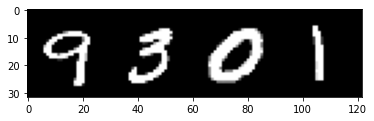

    9     3     0     1


In [6]:
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

We will use simple network with two convolutional layers and two linear layers

In [7]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

In [9]:
ensemble = []
for i in range(num_networks):
    new_net = Net()
    new_net.to(device)
    ensemble.append(new_net)

In [10]:
%%time
for net_id, net in enumerate(ensemble):
    optimizer = optim.SGD(net.parameters(), lr=learning_rate,
                      momentum=momentum)
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 300 == 299:    
                print(f'Network: {net_id} epoch: {epoch + 1} step: {i} loss: {round(running_loss/2000, 5)} ')
                running_loss = 0.0

print('Finished Training')


Network: 0 epoch: 1 step: 299 loss: 0.23045 
Network: 0 epoch: 1 step: 599 loss: 0.10454 
Network: 0 epoch: 1 step: 899 loss: 0.07892 
Network: 0 epoch: 2 step: 299 loss: 0.06506 
Network: 0 epoch: 2 step: 599 loss: 0.0577 
Network: 0 epoch: 2 step: 899 loss: 0.05441 
Network: 0 epoch: 3 step: 299 loss: 0.04942 
Network: 0 epoch: 3 step: 599 loss: 0.04697 
Network: 0 epoch: 3 step: 899 loss: 0.04368 
Network: 1 epoch: 1 step: 299 loss: 0.22487 
Network: 1 epoch: 1 step: 599 loss: 0.10296 
Network: 1 epoch: 1 step: 899 loss: 0.08061 
Network: 1 epoch: 2 step: 299 loss: 0.06297 
Network: 1 epoch: 2 step: 599 loss: 0.05738 
Network: 1 epoch: 2 step: 899 loss: 0.05285 
Network: 1 epoch: 3 step: 299 loss: 0.04823 
Network: 1 epoch: 3 step: 599 loss: 0.0444 
Network: 1 epoch: 3 step: 899 loss: 0.04269 
Network: 2 epoch: 1 step: 299 loss: 0.24886 
Network: 2 epoch: 1 step: 599 loss: 0.10192 
Network: 2 epoch: 1 step: 899 loss: 0.07642 
Network: 2 epoch: 2 step: 299 loss: 0.06149 
Network: 2 e

In [11]:
for net in ensemble:
    net.eval()

In [12]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

In [13]:
predictions = net(images)
probabilities = predictions.exp()

In [17]:
def predict_uncertainties(ensemble, images):
    all_probabilities = []
    for net in ensemble:
        net.eval()
        probs = net(images).exp()
        all_probabilities.append(probs)
    # Now probs is a list with num_networks tensors of size (bs x num_classes)
    expected_probability = torch.mean(torch.stack(all_probabilities), dim=0)
    # Total uncertainty
    entropy_of_expected = torch.sum(-expected_probability * torch.log(expected_probability), dim=1) 
    # Data uncertainty
    expected_entropy = torch.mean(
        torch.stack(
            [torch.sum(-prob * torch.log(prob), dim=1) for prob in all_probabilities]),
        dim=0)
    return expected_probability, entropy_of_expected, expected_entropy

In [19]:
expected_probability, entropy_of_expected, expected_entropy = predict_uncertainties(ensemble, images)

In [21]:
knowledge_uncertainty = entropy_of_expected - expected_entropy

### Predictions of one network

In [22]:
net = ensemble[0]
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to('cuda'), data[1].to('cuda')
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %


### Ensemble mean prediction

In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to('cuda'), data[1].to('cuda')
        outputs = torch.log(torch.mean(torch.stack([net(images).exp() for net in ensemble]), dim=0))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


## Uncertainties

In [24]:
all_expected_probability = []
all_entropy_of_expected = []
all_expected_entropy = []
all_knowledge_uncertainty = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to('cuda'), data[1].to('cuda')
        expected_probability, entropy_of_expected, expected_entropy = predict_uncertainties(ensemble, images)
        knowledge_uncertainty = entropy_of_expected - expected_entropy

        all_expected_probability.append(expected_probability.cpu().numpy())
        all_entropy_of_expected.append(entropy_of_expected.cpu().numpy())
        all_expected_entropy.append(expected_entropy.cpu().numpy())
        all_knowledge_uncertainty.append(knowledge_uncertainty.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

In [25]:
all_expected_probability = np.vstack(all_expected_probability)
all_entropy_of_expected = np.hstack(all_entropy_of_expected)
all_expected_entropy = np.hstack(all_expected_entropy)
all_knowledge_uncertainty = np.hstack(all_knowledge_uncertainty)
all_labels = np.hstack(all_labels)

In [26]:
all_predictions = np.argmax(all_expected_probability, axis=1)

errors = (all_predictions != all_labels).astype(int)

### Total uncertainty

**We can use total uncertainty to understand if we are certain in our predictions. If we are not certain, we can use some other model, or human evaluation. More about use cases you can find in our video about uncertainty applications.**

/home/iv-provilkov/miniconda3/envs/unc1/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


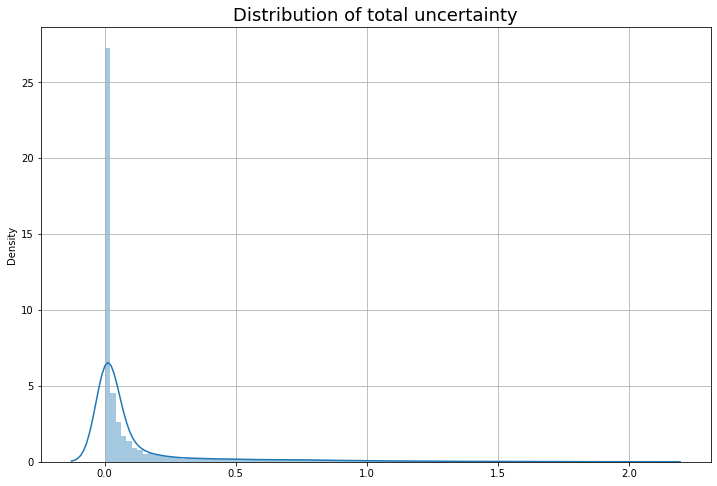

In [28]:
fig = plt.figure(figsize=(12,8))
sns.distplot(all_entropy_of_expected, bins=100)
plt.title('Distribution of total uncertainty', fontsize=18)
plt.grid()

In [27]:
total_uncertainty_order_error_cumsum = np.cumsum(errors[all_entropy_of_expected.argsort()])

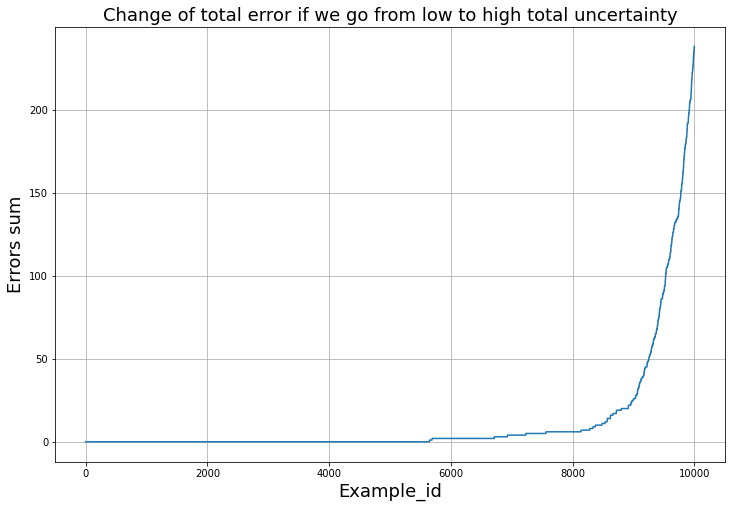

In [30]:
fig = plt.figure(figsize=(12,8))
plt.plot(total_uncertainty_order_error_cumsum)
plt.xlabel('Example_id', fontsize=18)
plt.ylabel('Errors sum', fontsize=18)
plt.title("Change of total error if we go from low to high total uncertainty", fontsize=18)
plt.grid()

### Knowledge uncertainty

OOD detection

In [31]:
images.shape

torch.Size([200, 1, 28, 28])

In [32]:
ood_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('./data/',  train=False, 
                                      transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                     ]), download=True), 
    batch_size=batch_size_test, shuffle=False)

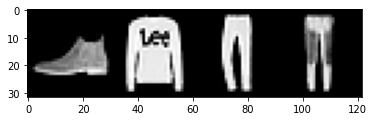

    9     2     1     1


In [33]:
dataiter = iter(ood_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [36]:
f_all_expected_probability = []
f_all_entropy_of_expected = []
f_all_expected_entropy = []
f_all_knowledge_uncertainty = []
f_all_labels = []
with torch.no_grad():
    for data in ood_loader:
        images, labels = data[0].to('cuda'), data[1].to('cuda')
        expected_probability, entropy_of_expected, expected_entropy = predict_uncertainties(ensemble, images)
        knowledge_uncertainty = entropy_of_expected - expected_entropy

        f_all_expected_probability.append(expected_probability.cpu().numpy())
        f_all_entropy_of_expected.append(entropy_of_expected.cpu().numpy())
        f_all_expected_entropy.append(expected_entropy.cpu().numpy())
        f_all_knowledge_uncertainty.append(knowledge_uncertainty.cpu().numpy())
        f_all_labels.append(labels.cpu().numpy())

In [37]:
f_all_expected_probability = np.vstack(f_all_expected_probability)
f_all_entropy_of_expected = np.hstack(f_all_entropy_of_expected)
f_all_expected_entropy = np.hstack(f_all_expected_entropy)
f_all_knowledge_uncertainty = np.hstack(f_all_knowledge_uncertainty)
f_all_labels = np.hstack(f_all_labels)

In [38]:
f_all_predictions = np.argmax(f_all_expected_probability, axis=1)

errors = (f_all_predictions != f_all_labels).astype(int)

In [39]:
print(f'Accuracy: {(1 - errors).sum() / errors.shape[0]}')

Accuracy: 0.0517


/home/iv-provilkov/miniconda3/envs/unc1/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/iv-provilkov/miniconda3/envs/unc1/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


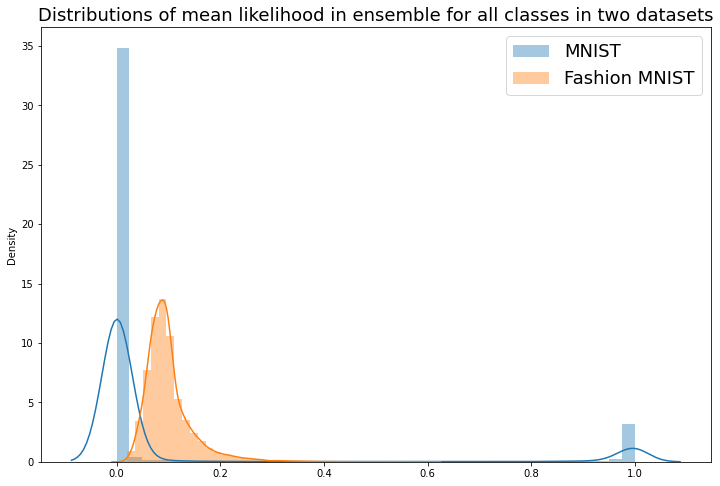

In [186]:
fig = plt.figure(figsize=(12,8))
sns.distplot(all_expected_probability.flatten(), label='MNIST', bins=40)
sns.distplot(f_all_expected_probability.flatten(), label='Fashion MNIST', bins=40)
plt.title("Distributions of mean likelihood in ensemble for all classes in two datasets", fontsize=18)
plt.legend(fontsize=18)

/home/iv-provilkov/miniconda3/envs/unc1/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/iv-provilkov/miniconda3/envs/unc1/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


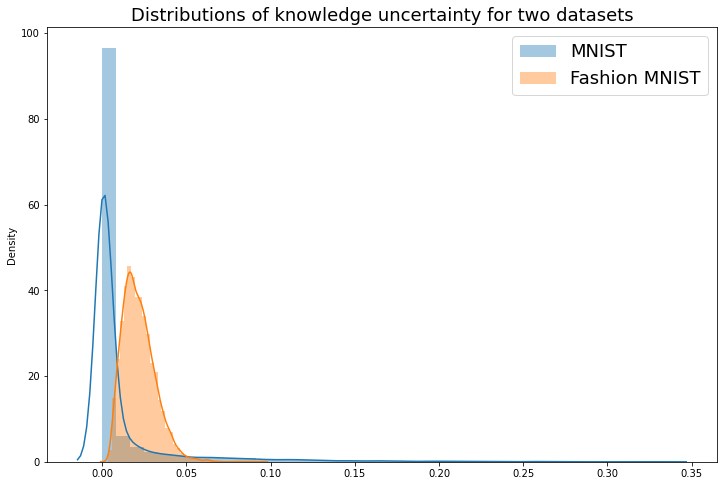

In [41]:
fig = plt.figure(figsize=(12,8))
sns.distplot(all_knowledge_uncertainty, label='MNIST', bins=40)
sns.distplot(f_all_knowledge_uncertainty, label='Fashion MNIST', bins=40)
plt.title("Distributions of knowledge uncertainty for two datasets", fontsize=18)
plt.legend(fontsize=18)

### OOD Detection

**We will use fashion-MNIST as OOD data**

In [42]:
from sklearn.metrics import roc_auc_score

In [43]:
y_true = np.zeros(20000)
y_true[10000:] = 1
knowledge_scores = np.hstack([all_knowledge_uncertainty, f_all_knowledge_uncertainty])
data_scores = np.hstack([all_expected_entropy, f_all_expected_entropy])
total_scores = np.hstack([all_entropy_of_expected, f_all_entropy_of_expected])

In [44]:
print(f'ROC-AUC score with knowledge uncertainty: {roc_auc_score(y_true, knowledge_scores)}')
print(f'ROC-AUC score with data uncertainty: {roc_auc_score(y_true, data_scores)}')
print(f'ROC-AUC score with total uncertainty: {roc_auc_score(y_true, total_scores)}')

ROC-AUC score with knowledge uncertainty: 0.864588025
ROC-AUC score with data uncertainty: 0.99998885
ROC-AUC score with total uncertainty: 0.99997749


### Calibration

**It is usually useful to check the match of the real distribution of classes with the distribution of model probabilities.**

/home/iv-provilkov/miniconda3/envs/unc1/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Calibration of our model')

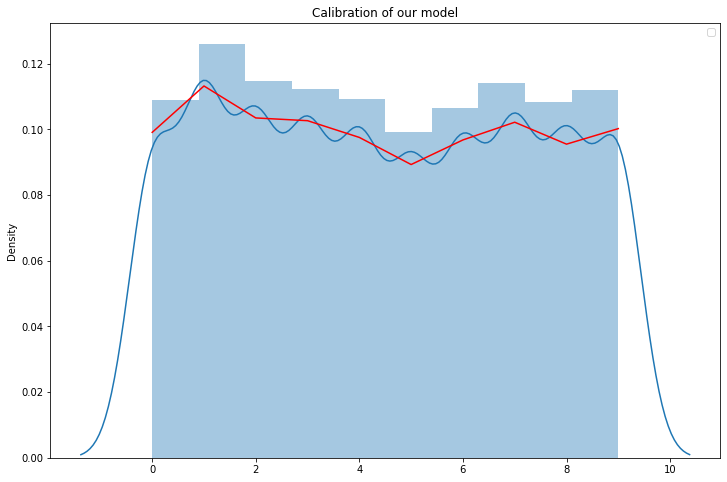

In [165]:
fig = plt.figure(figsize=(12,8))
sns.distplot(all_labels, bins=10)
plt.plot(np.arange(0, 10), all_expected_probability.mean(axis=0), color='red')
plt.legend()
plt.title("Calibration of our model")

**Here our calibration is good--model distribution over classes is very similar to the real distribution of classes.**

**In case of bad calibration -- if your model distribution over classes is very different from real distribution, you should try to fix this. For classification tasks it could be fixed with temperature techniques**

## Deep ensembles for Regression

**For regression tasks you should consider other distributions, but in general techniques are the same**

**We still have the same formulas for uncertainties:**

#### Through ensemble we can calculate *Total uncertainty*:
#### $$H[\mathbb{E}_{\theta \sim P(\theta|D)} [P(y|x^*, \theta)]] $$
#### and *Expected data uncertainty*:
#### $$\mathbb{E}_{\theta \sim P(\theta|D)} [H[P(y|x^*, \theta)]] $$
#### *Knowledge uncertainty* is the difference between *Total uncertainty* and *Expected Data uncertainty*:
#### $$\mathcal{I}(y, \theta| x^*, D) = H[\mathbb{E}_{\theta \sim P(\theta|D)} [P(y|x^*, \theta)]] - \mathbb{E}_{\theta \sim P(\theta|D)} [H[P(y|x^*, \theta)]]$$

#### Gaussian ensemble for different uncertainty cases:
<img src="./images/regression_ensemble.png">

**Here we will use simple toy dataset to show concepts.** 
**For ease of understanding, we will import models and functions from source files, that you can find in the repository. You can check them more precisely later. These classes are quite flexible and thoughtful, you can use them with other tasks.**

In [45]:
from src.data.toy_loading import get_toy_dataset, get_arrays_from_loader
from torch.utils import data
from torch.distributions import Normal
from torch.optim import SGD, Adam
import numpy as np

In [46]:
import random

In [47]:
targets_fn = lambda x: np.sin(x) + x / 10.0
noise_fn = lambda x: 1.0 / (1.0 + np.abs(x)) + 0.1


In [48]:
train_data, test_data, ood_full_data, y_noise = get_toy_dataset(
    targets_fn, noise_fn, train_limits=(-10, 10), ood_abs_limits=(20, 25),
    test_limits=(-15, 15),
    train_samples=2048, test_samples=512, ood_samples=512,
    random_state=12
)

trainloader = data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = data.DataLoader(test_data, batch_size=512)
oodloader = data.DataLoader(
    data.TensorDataset(ood_full_data.tensors[0]),
    batch_size=128, shuffle=True
)

print("Train size:", len(trainloader) * trainloader.batch_size, len(trainloader))
print("OOD size:", len(oodloader) * oodloader.batch_size, len(oodloader))
print("Test size:", len(testloader) * testloader.batch_size, len(testloader))

Train size: 2048 16
OOD size: 512 4
Test size: 512 1


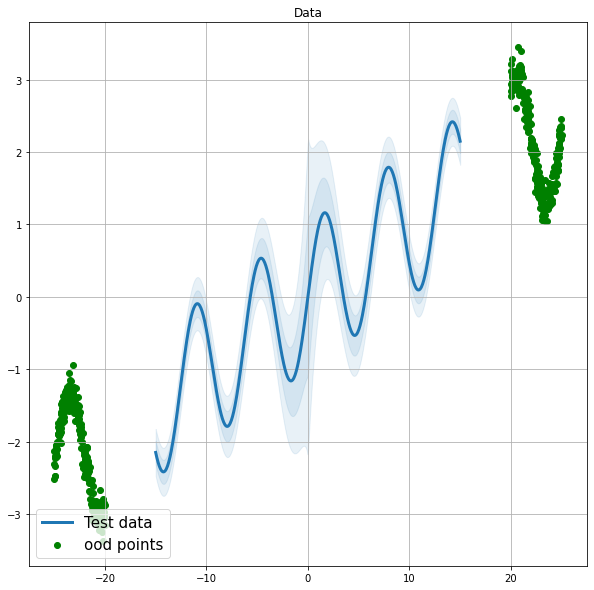

In [49]:
X_train, y_train = get_arrays_from_loader(trainloader)
X_ood, y_ood = ood_full_data.tensors[0], ood_full_data.tensors[1]
X_test, y_test = get_arrays_from_loader(testloader)
test_ord = X_test.argsort(0)
X_test, y_test = X_test[test_ord].squeeze(), y_test[test_ord].squeeze()

plt.figure(figsize=(10,10))
plt.title("Data")
plt.rc('font', size=30)
plt.plot(
    X_test, y_test,
    color=sns.color_palette()[0],
    linewidth=3, label="Test data"
)
plt.fill_between(
    X_test,
    y_test - noise_fn(X_test), 
    y_test + noise_fn(X_test), 
    color=sns.color_palette()[0], alpha=0.1
)
plt.fill_between(
    X_test,
    y_test - 2 * noise_fn(X_test), 
    y_test + 2 * noise_fn(X_test), 
    color=sns.color_palette()[0], alpha=0.1
)
plt.scatter(X_ood, y_ood, color='g',label='ood points')
plt.grid()
plt.legend(loc='lower left', fontsize=15)

In [50]:
from src.models.simple_model import SimpleModel
from src.training.trainers import DistributionMLETrainer, DistributionEnsembleMLETrainer
from src.distributions.mixture_distribution import GaussianDiagonalMixture

In [51]:
model_params = {
    "input_dim": 1, "output_dim": 1,
    "num_units": 30, "num_hidden": 2
}
optim_params = {"lr": 1e-3, "weight_decay": 1e-4}
NUM_EPOCHS = 150
LOG_PER = 100

singletrainer = DistributionMLETrainer(
    model_params,
    SimpleModel, optim_params, distribution=Normal,
    optimizer=Adam
)

strain_hist, stest_hist, smetrics_hist = singletrainer.train(
    trainloader, NUM_EPOCHS, testloader, 
    log_per=LOG_PER, verbose=True
)
print("Trained Gaussian, final rmse %.3f" % smetrics_hist[-1][0])

Epoch 0 train loss 1.538 eval loss 1.366 eval params_rmse 1.008
Epoch 100 train loss 0.806 eval loss 1.282 eval params_rmse 1.057
Epoch 149 train loss 0.723 eval loss 1.212 eval params_rmse 1.401
Trained Gaussian, final rmse 1.401


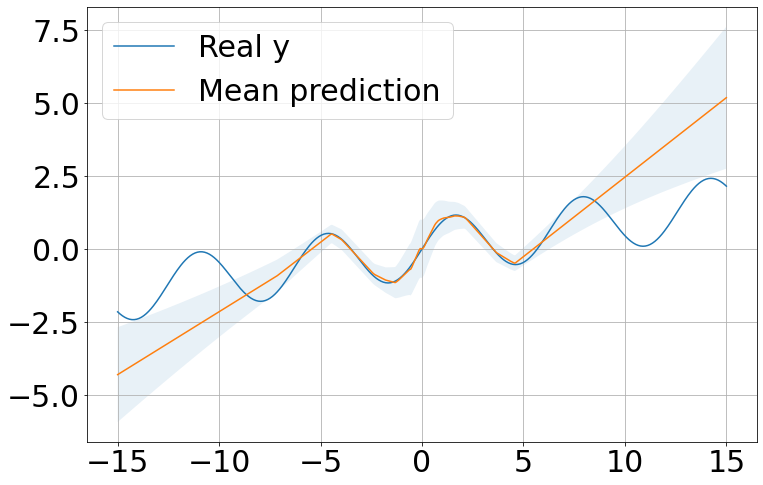

In [52]:
model_preds = singletrainer.get_predicted_params(testloader)
mean_preds, std_preds = model_preds[0][test_ord].squeeze(), model_preds[1][test_ord].squeeze()

fig=plt.figure(figsize=(12,8))
plt.plot(X_test, y_test, label="Real y")
plt.plot(X_test, mean_preds, label="Mean prediction")
plt.fill_between(X_test, mean_preds - std_preds, mean_preds + std_preds, alpha=0.1)
plt.legend()
plt.grid()
plt.show()

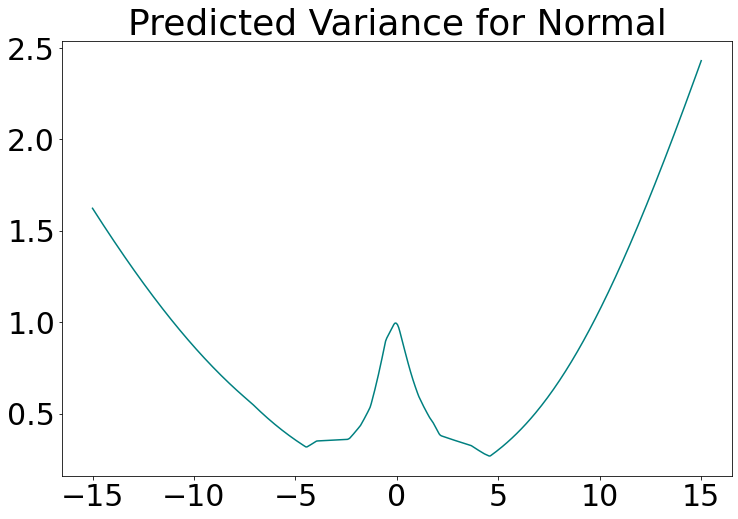

In [53]:
variances = singletrainer.get_predicted_params(testloader)[1]

fig=plt.figure(figsize=(12,8))
plt.title("Predicted Variance for Normal")
plt.plot(X_test, variances, color='teal', label='variances')

In [54]:
ensembletrainer = DistributionEnsembleMLETrainer(
    10, GaussianDiagonalMixture,
    model_params,
    SimpleModel, optim_params, distribution=Normal,
    optimizer=Adam
)

In [55]:
entrain_hist, enval_hist, enmetrics_hist = ensembletrainer.train(
    trainloader, NUM_EPOCHS, testloader, 
    log_per=LOG_PER, verbose=True
)
print("Trained Ensemble, final rmse %.3f" % enmetrics_hist[-1][-1][0])

--------------------
Model 0
Epoch 0 train loss 1.588 eval loss 1.442 eval params_rmse 1.038
Epoch 100 train loss 0.898 eval loss 1.286 eval params_rmse 0.778
Epoch 149 train loss 0.773 eval loss 1.308 eval params_rmse 1.221
--------------------
Model 1
Epoch 0 train loss 1.584 eval loss 1.404 eval params_rmse 1.042
Epoch 100 train loss 0.811 eval loss 1.149 eval params_rmse 1.209
Epoch 149 train loss 0.770 eval loss 1.267 eval params_rmse 1.409
--------------------
Model 2
Epoch 0 train loss 1.479 eval loss 1.245 eval params_rmse 0.866
Epoch 100 train loss 0.771 eval loss 1.066 eval params_rmse 0.754
Epoch 149 train loss 0.677 eval loss 1.039 eval params_rmse 0.957
--------------------
Model 3
Epoch 0 train loss 1.511 eval loss 1.260 eval params_rmse 0.849
Epoch 100 train loss 0.887 eval loss 1.194 eval params_rmse 1.015
Epoch 149 train loss 0.809 eval loss 1.181 eval params_rmse 1.307
--------------------
Model 4
Epoch 0 train loss 1.550 eval loss 1.413 eval params_rmse 1.045
Epoch 1

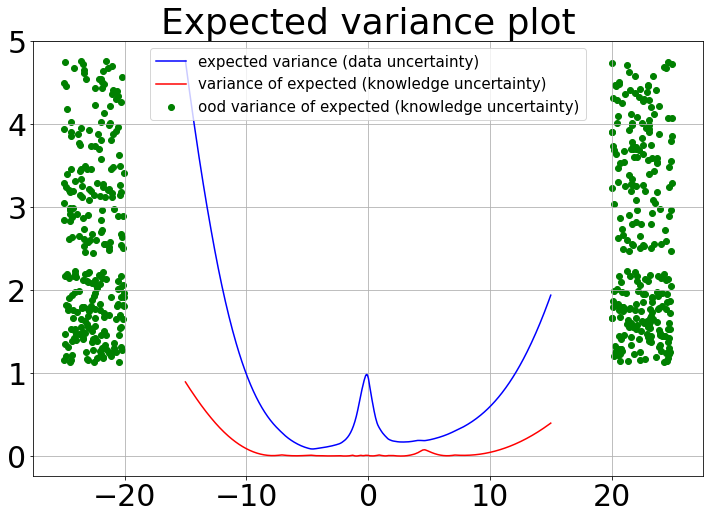

In [56]:
ev_scores = ensembletrainer.eval_uncertainty(
    testloader, "expected_variance"
)[test_ord].squeeze()

fig = plt.figure(figsize=(12,8))
plt.title("Expected variance plot")
plt.plot(X_test, ev_scores, color='b', label='expected variance (data uncertainty)')
#%%
# Show estimated knowledge uncertainty
voe_scores = ensembletrainer.eval_uncertainty(
    testloader, "variance_of_expected"
)[test_ord].squeeze()

ood_voe_scores = ensembletrainer.eval_uncertainty(
    oodloader, "variance_of_expected")
plt.plot(X_test, voe_scores, label='variance of expected (knowledge uncertainty)', color='r')
plt.scatter(X_ood, ood_voe_scores, label='ood variance of expected (knowledge uncertainty)', color='g')
plt.grid()
plt.legend(fontsize=15)
plt.show()

## Ensemble distribution distillation into Prior Network

**We can distill an ensemble into one model, to reduce computational time during inference, while saving predictions quality.**

**If we use usual knowledge distillation: ensemble of normal models into another normal model, then we lose possibility to calculate uncertainty measures. Ensemble distribution distillation is to solve this problem. It allows us to distill an ensemble into Prior Network, saving possibility to calculate uncertainty measures.**

**Prior Network is the distribution over distributions. For example we can use Normal-Wishart distribution in Prior Network for an ensemble of Normal distributions, as you can sample parameters of Normal distribution from Normal-Wishart distribution.**

In [59]:
from src.training.ood_trainers import DistributionEnsembleToPriorDistiller
from src.distributions.prior_distribution import NormalWishartPrior

In [60]:
loss_params = {
    "max_temperature": 1.0,
    "noise_level": 3.0
}
model_params["isPrior"] = True
prior_distiller = DistributionEnsembleToPriorDistiller(
    [ensembletrainer.trainers[i].model for i in range(10)],
    loss_params, model_params, SimpleModel,
    optim_params, distribution=NormalWishartPrior, optimizer=Adam
)
ptrain_hist, pval_hist, pmetrics_hist = prior_distiller.train(
    trainloader, NUM_EPOCHS, testloader, 
    log_per=LOG_PER, verbose=True
)
print("Distilled NWPrior, final rmse %.3f" % pmetrics_hist[-1][0])

Epoch 0 train loss 608.501 eval loss 2305.013 eval params_rmse 1.077
Epoch 100 train loss 156.554 eval loss 788.144 eval params_rmse 1.065
Epoch 149 train loss 135.326 eval loss 676.144 eval params_rmse 1.055
Distilled NWPrior, final rmse 1.055


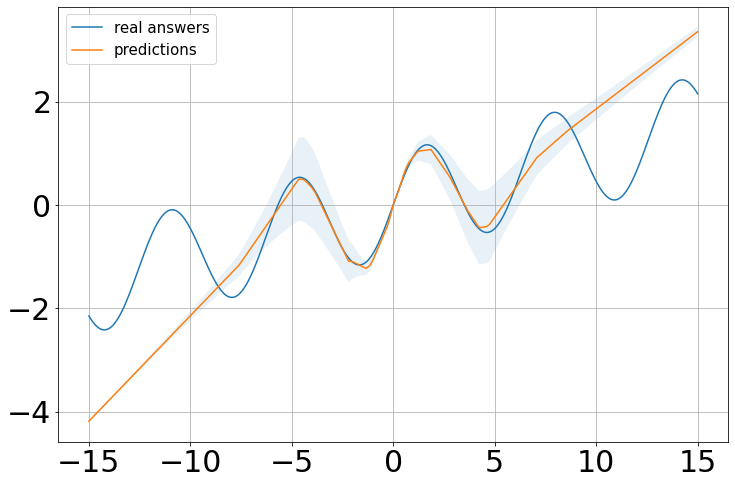

In [64]:
model_preds = prior_distiller.get_predicted_params(testloader)
mean_preds, std_preds = model_preds[0][test_ord].squeeze(), model_preds[1][test_ord].squeeze()

fig = plt.figure(figsize=(12,8))
plt.plot(X_test, y_test, label="real answers")
plt.plot(X_test, mean_preds, label='predictions')
plt.fill_between(X_test, mean_preds - std_preds, mean_preds + std_preds, alpha=0.1)
plt.grid()
plt.legend(fontsize=15)
plt.show()

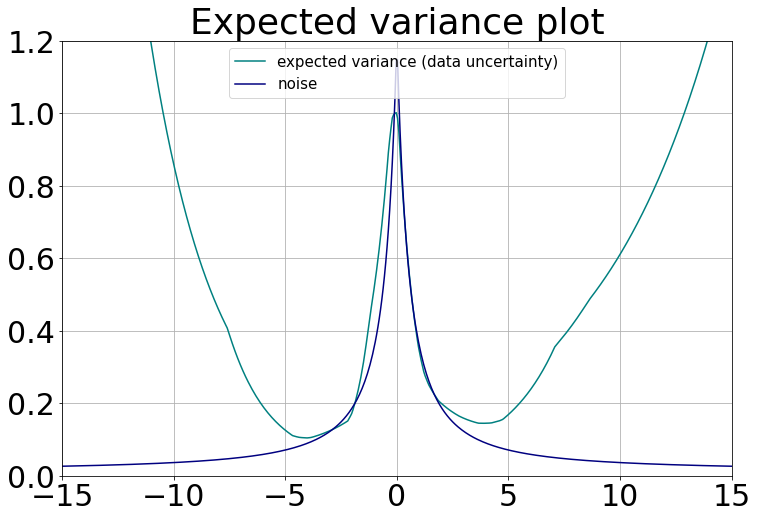

In [65]:
# Show data uncertainty
ev_scores = prior_distiller.eval_uncertainty(
    testloader, "expected_variance"
)[test_ord].squeeze()

fig = plt.figure(figsize=(12,8))
plt.title("Expected variance plot")
plt.plot(X_test, ev_scores, color='teal', label='expected variance (data uncertainty)')
plt.plot(X_test, noise_fn(X_test).pow(2), color='navy', label='noise')
plt.xlim(-15, 15)
plt.ylim(0, 1.2)
plt.grid()
plt.legend(fontsize=15)

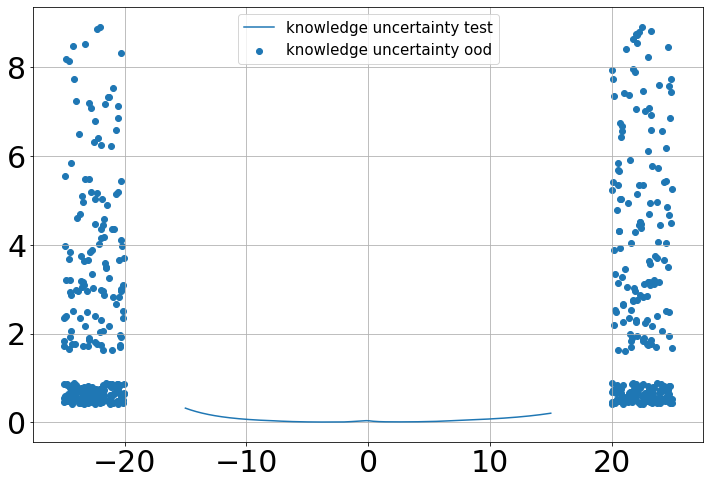

In [67]:
#%%
# Show knowledge uncertainty

fig = plt.figure(figsize=(12,8))
voe_scores = prior_distiller.eval_uncertainty(
    testloader, "variance_of_expected"
)[test_ord].squeeze()
ood_voe_scores = prior_distiller.eval_uncertainty(
    oodloader, "variance_of_expected"
)[test_ord].squeeze()
plt.plot(X_test, voe_scores, label="knowledge uncertainty test")
plt.scatter(X_ood, ood_voe_scores, label="knowledge uncertainty ood")
#plt.scatter(X_ood, y_ood, color='g',label='ood points')
#plt.ylim(0, 2.0)
plt.grid()
plt.legend(fontsize=15)
plt.show()

**Notebook:https://github.com/VProv/uncertainty_example**

**Find more interesting videos in our track:https://ods.ai/tracks/uncertainty-estimation-in-ml-df2020**

**Regression Prior Networks: https://github.com/JanRocketMan/regression-prior-networks**